# About this notebook

## Version1
- PyTorch attention lstm starter code
- 60 epochs
- batch size 32 no accumulation
- AdamW optimizer
- No weight initialization
- hidden size 512

# Library

In [1]:
import os
import random
from tqdm.auto import tqdm
import time
import wandb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau,
OneCycleLR)
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

DIR = './'
if not os.path.exists(DIR):
    os.mkdir(DIR)

device=("cuda" if torch.cuda.is_available() else "cpu")
VERSION=1

# Load data

In [2]:
data = pd.read_csv('../input/beijing-air-quality-preprocessed/airquality_data.csv')
FEATURES_COLUMNS = [col for col in data.columns if col not in ['No', 'year', 'month', 'day', 'hour']]

# Configuration

In [3]:
class CFG:
    apex=False
    debug=False
    kaggle = True
    print_freq=500
    num_workers=1
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=60
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':5,
        'eta_min':1e-4,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3
    }
    batch_size=32 #64
    lr=1e-4
    weight_decay=1e-2
    gradient_accumulation_steps=1
    max_grad_norm=1000 # Gradient clipping to prevent exploding / vanishing gradient 
    target_size=1
    num_layers=2
    input_size=len(FEATURES_COLUMNS)
    enc_hidden_size=512 # Encoder hidden dim
    dec_hidden_size=512 # Decoder hidden dim
    seq_length=48 # 48h
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    target_col="PM2.5"
    model_name="attention_lstm_network"
    group = 'attention lstm'
    train=True
    seed=42
    
if CFG.debug:
    CFG.epochs=2
    data=data.sample(n=10000, random_state=CFG.seed).reset_index(drop=True).fillna(method="ffill")

# Data Preprocessing

### Train test split

In [4]:
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [5]:
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

# Utils

In [6]:
def get_score(y_true, y_pred):
    score = math.sqrt(mse(y_true, y_pred))
    return score

def init_logger(log_file=DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=45)


def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    
    sequences = []
    data_size = input_data.shape[0]
    for i in tqdm(range(data_size - sequence_length)):
        
        sequence = input_data[i: i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence[FEATURES_COLUMNS], label))
        
    return sequences

### Create sequences from  data

In [7]:
%%time
train_sequence = create_sequences(train, CFG.target_col, CFG.seq_length)
valid_sequence = create_sequences(valid, CFG.target_col, CFG.seq_length)
test_sequence = create_sequences(test, CFG.target_col, CFG.seq_length)

  0%|          | 0/325268 [00:00<?, ?it/s]

  0%|          | 0/36099 [00:00<?, ?it/s]

  0%|          | 0/40115 [00:00<?, ?it/s]

CPU times: user 5min 29s, sys: 17 s, total: 5min 46s
Wall time: 5min 28s


# Pytorch Dataset

In [8]:
class AirQualityDataset(Dataset):
    
    def __init__(self, sequences):
        
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        
        sequence, target = self.sequences[idx]
        
        return torch.tensor(sequence.to_numpy()).float(), torch.tensor(target).float()

In [9]:
train_dataset = AirQualityDataset(train_sequence)
sequence, label = train_dataset[0]
print(f'sequence shape: {sequence.shape}')
print(f'label shape: {label.shape}')

sequence shape: torch.Size([48, 13])
label shape: torch.Size([])


# W&B

In [10]:
if CFG.kaggle:
    
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    wandb_api = user_secrets.get_secret("wandb_key")

    wandb.login(key=wandb_api)

else:
    
    wandb.login()

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Baijing airquality prediction", 
                 name=CFG.model_name,
                 config=class2dict(CFG),
                 group=CFG.group,
                 tags=[f'CFG.model_name_version{VERSION}'],
                 job_type="train")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: djoe. Use `wandb login --relogin` to force relogin


# Model

In [11]:
class Encoder(nn.Module):
    def __init__(
                 self, 
                 input_size=CFG.input_size, 
                 enc_hidden_size=CFG.enc_hidden_size,
                 dec_hidden_size=CFG.dec_hidden_size,
                 num_layers=CFG.num_layers
                ):
        
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.enc_hidden_size = enc_hidden_size
        self.seq_length = CFG.seq_length
        
        self.rnn = nn.LSTM(
                            input_size=self.input_size, # Features of the sequence
                            hidden_size=self.enc_hidden_size, # Hidden units for the lstm
                            num_layers=self.num_layers, # Number of layers
                            batch_first=True, # (batch, seq, features)
                            dropout=0.2,
                            bidirectional=True
                           )
        
        self.fc = nn.Linear(enc_hidden_size * 2, dec_hidden_size)
        
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        
        outputs, (h_out, _) = self.rnn(src)
        #print('h_out shape:', h_out.shape)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((h_out[-2,:,:], h_out[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden
    
class Attention(nn.Module):
    def __init__(
                 self,
                 enc_hidden_dim=CFG.enc_hidden_size,
                 dec_hidden_dim=CFG.dec_hidden_size
                ):
        
        super(Attention, self).__init__()
        
        self.attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #print("hidden shape: ", hidden.shape)
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        #print("hidden shape: ", hidden.shape)
        #print("encoder_outputs shape: ", encoder_outputs.shape)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]
        #print('energy shape: ', energy.shape)

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        #print('attention shape: ', attention.shape)
        
        return F.softmax(attention, dim=1)
    
class Decoder(nn.Module):
    def __init__(
                 self, 
                 target_size=CFG.target_size, 
                 input_size=CFG.input_size,
                 num_layers=CFG.num_layers,
                 enc_hidden_size=CFG.enc_hidden_size,
                 dec_hidden_size=CFG.dec_hidden_size,
                 attention=None
                ):
        
        super(Decoder, self).__init__()

        self.target_size = target_size
        self.attention = attention
        self.num_layers = num_layers
        self.input_size = input_size
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.seq_length = CFG.seq_length
        
        #self.embedding = nn.Embedding(output_dim, emb_dim)
        
        #self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.rnn = nn.LSTM(
                            input_size= self.enc_hidden_size * 2 + self.input_size, # Features of the sequence
                            hidden_size=self.dec_hidden_size, # Hidden units for the lstm
                            num_layers=self.num_layers, # Number of layers
                            batch_first=True, # (batch, seq, features)
                            dropout=0.2,
                            bidirectional=False
                           )
        
        self.fc_out = nn.Linear(self.dec_hidden_size, self.target_size)
        
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size, seq_len, input__size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        
                
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.repeat(1, CFG.seq_length, 1)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((input, weighted), dim = 2)
        
        #rnn_input = [batch size, seq_len, (enc hid dim * 2) + emb dim]
            
        output, (hidden, _) = self.rnn(rnn_input)
        
        #output = [batch size, seq len, dec hid dim]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        
        hidden = hidden[-1]
        prediction = self.fc_out(hidden)
        
        #prediction = [batch size, output dim]
        
        return prediction

class AttentionLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super(AttentionLSTM, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, seq):
        
        outputs, hidden = self.encoder(seq)
        predictions = self.decoder(seq, hidden, outputs)
        
        return predictions

# Helper Functions

In [12]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (sequences, targets) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(sequences)
                loss = criterion(y_preds.squeeze(1), targets)
        else:
            y_preds = model(sequences)
            loss = criterion(y_preds.squeeze(1), targets)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        if fold:
            
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
        else:
            
            wandb.log({"loss": losses.val,
                       "lr": scheduler.get_last_lr()[0]})
            
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    targets_list = []
    start = end = time.time()
    for step, (sequences, targets) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        #num = dct['num_data'].to(device)
        #cat = dct['cat_data'].to(device)
        sequences = sequences.to(device)
        targets = targets.to(device)
        batch_size = targets.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(sequences)
        preds.append(y_preds.detach().to('cpu').numpy())
        targets_list.append(targets.detach().to('cpu').numpy())
        
        loss = criterion(y_preds.squeeze(1), targets)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    targets = np.concatenate(targets_list)
    return losses.avg, predictions, targets

# ====================================================
# inference
# ====================================================
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    forcasts = []
    targets_list = []
    for i, (sequences, targets) in enumerate(tk0):
        sequences = sequences.to(device).float()
        targets = targets.to(device).float()
        avg_forcasts = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(sequences)
            avg_forcasts.append(y_preds.detach().to("cpu").numpy())
        avg_forcasts = np.mean(avg_forcasts, axis=0)
        forcasts.append(avg_forcasts)
        targets_list.append(targets.detach().to("cpu").numpy())
    forcasts = np.concatenate(forcasts)
    targets = np.concatenate(targets_list)
    return forcasts, targets

# Train Loop

In [13]:
####################################################
############## Dataloader for pytorch ##############
####################################################

seed_torch(seed=45)
train_dataset = AirQualityDataset(train_sequence)

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.batch_size, 
                          shuffle=False, # Time series data
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)


valid_dataset = AirQualityDataset(valid_sequence)

valid_loader = DataLoader(valid_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


test_dataset = AirQualityDataset(test_sequence)

test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size, 
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================

encoder = Encoder()
attention = Attention()
decoder = Decoder(attention=attention)
model = AttentionLSTM(encoder=encoder, decoder=decoder)
model.to(device)
optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = get_scheduler(optimizer)

# ====================================================
# loop
# ====================================================
criterion = nn.MSELoss()
best_loss = np.inf

for epoch in range(CFG.epochs):
        
    start_time = time.time()
    
    
    # train
    avg_loss = train_fn(None, train_loader, model, criterion, optimizer, epoch, scheduler, device)
    
    # eval
    avg_val_loss, valid_preds, valid_targets = valid_fn(valid_loader, model, criterion, device)
    
    

    
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    # scoring
    score = get_score(valid_targets, valid_preds)
    elapsed = time.time() - start_time
    
        
    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
    wandb.log({f" epoch": epoch+1, 
               f" avg_train_loss": avg_loss, 
               f" avg_val_loss": avg_val_loss,
               f" score": score
              })
    # Save best weights    
    if avg_val_loss < best_loss:
        LOGGER.info(f"Validation loss Improved ({best_loss} ---> {avg_val_loss})")
        best_loss = avg_val_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict(), 
                    'preds_loss': valid_preds,
                    'targets': valid_targets},
                    DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth')
        
# Inference
states = [torch.load(DIR+f'{CFG.model_name}_best_loss_version{VERSION}.pth', map_location=device)]
valid_targets = states[0]['targets']
valid_predictions = states[0]['preds_loss']
test_preds, test_targets = inference(model, states, test_loader, device)
LOGGER.info(f'RMSE score on validation set: {get_score(valid_targets, valid_predictions)}')
LOGGER.info(f'RMSE score on test set: {get_score(test_targets, test_preds)}')

Epoch: [1][0/10164] Elapsed 0m 1s (remain 317m 11s) Loss: 5663.4570(5663.4570) Grad: 1242.5771 LR: 0.000100  
Epoch: [1][500/10164] Elapsed 0m 28s (remain 9m 4s) Loss: 783.2970(6349.2370) Grad: 352.2349 LR: 0.000100  
Epoch: [1][1000/10164] Elapsed 0m 54s (remain 8m 18s) Loss: 2416.2688(5054.9219) Grad: 1954.1975 LR: 0.000100  
Epoch: [1][1500/10164] Elapsed 1m 20s (remain 7m 44s) Loss: 13930.6240(4533.4328) Grad: 4345.2764 LR: 0.000100  
Epoch: [1][2000/10164] Elapsed 1m 46s (remain 7m 15s) Loss: 541.9328(3913.1809) Grad: 14894.9795 LR: 0.000100  
Epoch: [1][2500/10164] Elapsed 2m 12s (remain 6m 46s) Loss: 166.1312(3611.9800) Grad: 5491.5786 LR: 0.000100  
Epoch: [1][3000/10164] Elapsed 2m 38s (remain 6m 19s) Loss: 76.7788(3271.5209) Grad: 16143.2402 LR: 0.000100  
Epoch: [1][3500/10164] Elapsed 3m 4s (remain 5m 52s) Loss: 135.2372(3054.5403) Grad: 11233.6074 LR: 0.000100  
Epoch: [1][4000/10164] Elapsed 3m 31s (remain 5m 25s) Loss: 116.9358(2805.5440) Grad: 7317.0034 LR: 0.000100  
E

Epoch 1 - avg_train_loss: 1539.1796  avg_val_loss: 636.3656  time: 549s
Epoch 1 - Score: 25.2263
Validation loss Improved (inf ---> 636.3655571588971)
Epoch 1 - Save Best Loss: 636.3656 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 733.4997(636.3656) 
Epoch: [2][0/10164] Elapsed 0m 0s (remain 18m 35s) Loss: 366.3596(366.3596) Grad: 54180.5820 LR: 0.000094  
Epoch: [2][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 88.2751(486.9425) Grad: 10178.2363 LR: 0.000094  
Epoch: [2][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 436.0604(454.4157) Grad: 23602.7598 LR: 0.000094  
Epoch: [2][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 1914.4235(458.0808) Grad: 18980.7910 LR: 0.000094  
Epoch: [2][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 102.7777(442.2833) Grad: 31084.3164 LR: 0.000094  
Epoch: [2][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 57.3392(436.1593) Grad: 20698.6855 LR: 0.000094  
Epoch: [2][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 72.8693(417.7188) Grad: 13562.9629 LR: 0.000094  
Epoch: [2][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 117.1418(421.1112) Grad: 17489.2969 LR: 0.000094  
Epoch: [2][4000/10164] Elapsed 3m 28s (remain 

Epoch 2 - avg_train_loss: 354.7154  avg_val_loss: 532.0013  time: 546s
Epoch 2 - Score: 23.0652
Validation loss Improved (636.3655571588971 ---> 532.0013184654287)
Epoch 2 - Save Best Loss: 532.0013 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 902.6562(532.0013) 
Epoch: [3][0/10164] Elapsed 0m 0s (remain 18m 53s) Loss: 406.9891(406.9891) Grad: 52693.8594 LR: 0.000078  
Epoch: [3][500/10164] Elapsed 0m 26s (remain 8m 27s) Loss: 86.6166(337.6411) Grad: 10708.4932 LR: 0.000078  
Epoch: [3][1000/10164] Elapsed 0m 52s (remain 8m 0s) Loss: 423.9003(318.8372) Grad: 30861.0391 LR: 0.000078  
Epoch: [3][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 672.5972(323.6126) Grad: 58016.2266 LR: 0.000078  
Epoch: [3][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 54.6094(323.4328) Grad: 3735.4734 LR: 0.000078  
Epoch: [3][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 35.5905(320.2784) Grad: 17528.8320 LR: 0.000078  
Epoch: [3][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 63.7353(308.0289) Grad: 11671.2500 LR: 0.000078  
Epoch: [3][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 111.0153(315.9519) Grad: 12384.3379 LR: 0.000078  
Epoch: [3][4000/10164] Elapsed 3m 29s (remain 5m 2

Epoch 3 - avg_train_loss: 297.9544  avg_val_loss: 493.9705  time: 547s
Epoch 3 - Score: 22.2254
Validation loss Improved (532.0013184654287 ---> 493.9704975914488)
Epoch 3 - Save Best Loss: 493.9705 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 792.7738(493.9705) 
Epoch: [4][0/10164] Elapsed 0m 0s (remain 19m 34s) Loss: 315.4518(315.4518) Grad: 36398.8398 LR: 0.000055  
Epoch: [4][500/10164] Elapsed 0m 26s (remain 8m 25s) Loss: 73.7431(321.3059) Grad: 9882.8428 LR: 0.000055  
Epoch: [4][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 407.0512(303.8327) Grad: 22179.3691 LR: 0.000055  
Epoch: [4][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 618.5436(309.3791) Grad: 47838.6328 LR: 0.000055  
Epoch: [4][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 68.1933(310.8943) Grad: 20457.6465 LR: 0.000055  
Epoch: [4][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 45.8811(307.6038) Grad: 20075.0137 LR: 0.000055  
Epoch: [4][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 67.9519(295.7969) Grad: 11912.8418 LR: 0.000055  
Epoch: [4][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 102.3564(304.4539) Grad: 4898.0747 LR: 0.000055  
Epoch: [4][4000/10164] Elapsed 3m 28s (remain 5m 2

Epoch 4 - avg_train_loss: 288.6897  avg_val_loss: 425.1573  time: 547s
Epoch 4 - Score: 20.6193
Validation loss Improved (493.9704975914488 ---> 425.1572696133437)
Epoch 4 - Save Best Loss: 425.1573 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 923.0334(425.1573) 
Epoch: [5][0/10164] Elapsed 0m 0s (remain 19m 9s) Loss: 348.7908(348.7908) Grad: 32381.0488 LR: 0.000033  
Epoch: [5][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 64.3409(310.5462) Grad: 7781.6060 LR: 0.000033  
Epoch: [5][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 422.9636(295.9269) Grad: 28652.1387 LR: 0.000033  
Epoch: [5][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 503.0029(300.1904) Grad: 47426.3281 LR: 0.000033  
Epoch: [5][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 59.6588(302.2318) Grad: 14647.6582 LR: 0.000033  
Epoch: [5][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 45.5143(298.9328) Grad: 20304.2305 LR: 0.000033  
Epoch: [5][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 78.0468(287.6220) Grad: 10671.1436 LR: 0.000033  
Epoch: [5][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 94.6235(296.5950) Grad: 5350.8169 LR: 0.000033  
Epoch: [5][4000/10164] Elapsed 3m 29s (remain 5m 22s

Epoch 5 - avg_train_loss: 281.8651  avg_val_loss: 321.2549  time: 548s
Epoch 5 - Score: 17.9236
Validation loss Improved (425.1572696133437 ---> 321.25488779921886)
Epoch 5 - Save Best Loss: 321.2549 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1218.7058(321.2549) 
Epoch: [6][0/10164] Elapsed 0m 0s (remain 19m 11s) Loss: 304.9037(304.9037) Grad: 28007.2988 LR: 0.000016  
Epoch: [6][500/10164] Elapsed 0m 26s (remain 8m 27s) Loss: 73.8234(307.9910) Grad: 8127.8516 LR: 0.000016  
Epoch: [6][1000/10164] Elapsed 0m 52s (remain 8m 0s) Loss: 426.5373(292.5534) Grad: 30500.9922 LR: 0.000016  
Epoch: [6][1500/10164] Elapsed 1m 18s (remain 7m 34s) Loss: 526.5627(296.0607) Grad: 76656.4688 LR: 0.000016  
Epoch: [6][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 47.6346(298.3662) Grad: 11301.2383 LR: 0.000016  
Epoch: [6][2500/10164] Elapsed 2m 10s (remain 6m 41s) Loss: 60.6232(294.6179) Grad: 24908.9590 LR: 0.000016  
Epoch: [6][3000/10164] Elapsed 2m 37s (remain 6m 15s) Loss: 53.2285(283.0388) Grad: 6249.6504 LR: 0.000016  
Epoch: [6][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 101.5676(291.7403) Grad: 5809.7500 LR: 0.000016  
Epoch: [6][4000/10164] Elapsed 3m 29s (remain 5m 22

Epoch 6 - avg_train_loss: 276.5912  avg_val_loss: 278.8408  time: 544s
Epoch 6 - Score: 16.6985
Validation loss Improved (321.25488779921886 ---> 278.84075585141824)
Epoch 6 - Save Best Loss: 278.8408 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1212.0293(278.8408) 
Epoch: [7][0/10164] Elapsed 0m 0s (remain 19m 56s) Loss: 306.8792(306.8792) Grad: 25780.4121 LR: 0.000010  
Epoch: [7][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 63.1490(302.4886) Grad: 7250.5879 LR: 0.000010  
Epoch: [7][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 454.0144(285.6653) Grad: 27957.6719 LR: 0.000010  
Epoch: [7][1500/10164] Elapsed 1m 18s (remain 7m 30s) Loss: 553.1914(289.7789) Grad: 80892.1875 LR: 0.000010  
Epoch: [7][2000/10164] Elapsed 1m 44s (remain 7m 4s) Loss: 45.5079(292.6787) Grad: 9626.4336 LR: 0.000010  
Epoch: [7][2500/10164] Elapsed 2m 10s (remain 6m 38s) Loss: 33.3427(288.8096) Grad: 14453.0117 LR: 0.000010  
Epoch: [7][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 48.5555(277.3532) Grad: 3834.9316 LR: 0.000010  
Epoch: [7][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 100.9338(286.1918) Grad: 6915.9888 LR: 0.000010  
Epoch: [7][4000/10164] Elapsed 3m 28s (remain 5m 21

Epoch 7 - avg_train_loss: 271.8587  avg_val_loss: 274.6246  time: 544s
Epoch 7 - Score: 16.5718
Validation loss Improved (278.84075585141824 ---> 274.62462630803316)
Epoch 7 - Save Best Loss: 274.6246 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1074.9977(274.6246) 
Epoch: [8][0/10164] Elapsed 0m 0s (remain 18m 44s) Loss: 276.6501(276.6501) Grad: 24065.7422 LR: 0.000016  
Epoch: [8][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 55.0513(298.3892) Grad: 7546.6284 LR: 0.000016  
Epoch: [8][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 433.6246(282.4283) Grad: 23083.0312 LR: 0.000016  
Epoch: [8][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 539.0321(287.1318) Grad: 65771.0391 LR: 0.000016  
Epoch: [8][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 48.3622(289.8263) Grad: 12021.7314 LR: 0.000016  
Epoch: [8][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 41.8940(286.5186) Grad: 16710.3164 LR: 0.000016  
Epoch: [8][3000/10164] Elapsed 2m 36s (remain 6m 12s) Loss: 51.1223(275.1296) Grad: 7638.7012 LR: 0.000016  
Epoch: [8][3500/10164] Elapsed 3m 2s (remain 5m 46s) Loss: 102.0495(283.7946) Grad: 5015.0571 LR: 0.000016  
Epoch: [8][4000/10164] Elapsed 3m 28s (remain 5m 2

Epoch 8 - avg_train_loss: 270.5628  avg_val_loss: 275.3608  time: 544s
Epoch 8 - Score: 16.5940


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1120.8945(275.3608) 
Epoch: [9][0/10164] Elapsed 0m 0s (remain 19m 10s) Loss: 307.8582(307.8582) Grad: 30242.5684 LR: 0.000033  
Epoch: [9][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 76.7753(298.9022) Grad: 11381.2627 LR: 0.000033  
Epoch: [9][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 380.8343(282.4308) Grad: 25963.9375 LR: 0.000033  
Epoch: [9][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 554.7222(287.5042) Grad: 76380.5234 LR: 0.000033  
Epoch: [9][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 47.7243(289.7720) Grad: 12031.3291 LR: 0.000033  
Epoch: [9][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 33.9763(286.4947) Grad: 10970.6240 LR: 0.000033  
Epoch: [9][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 54.3431(275.4229) Grad: 8085.6396 LR: 0.000033  
Epoch: [9][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 94.3002(284.3496) Grad: 3876.7607 LR: 0.000033  
Epoch: [9][4000/10164] Elapsed 3m 28s (remain 5m 2

Epoch 9 - avg_train_loss: 271.8330  avg_val_loss: 282.0597  time: 546s
Epoch 9 - Score: 16.7946


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 1032.8666(282.0597) 
Epoch: [10][0/10164] Elapsed 0m 0s (remain 19m 57s) Loss: 297.0264(297.0264) Grad: 25079.0078 LR: 0.000055  
Epoch: [10][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 74.3314(301.4097) Grad: 15873.0986 LR: 0.000055  
Epoch: [10][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 397.4041(286.1945) Grad: 22567.8828 LR: 0.000055  
Epoch: [10][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 594.0971(291.3421) Grad: 68784.1328 LR: 0.000055  
Epoch: [10][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 44.6679(293.2889) Grad: 5334.8442 LR: 0.000055  
Epoch: [10][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 39.9758(290.3255) Grad: 14801.7500 LR: 0.000055  
Epoch: [10][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 57.4369(279.4705) Grad: 9295.5752 LR: 0.000055  
Epoch: [10][3500/10164] Elapsed 3m 2s (remain 5m 48s) Loss: 106.8627(287.9981) Grad: 8309.0234 LR: 0.000055  
Epoch: [10][4000/10164] Elapsed 3m 29s (re

Epoch 10 - avg_train_loss: 276.0688  avg_val_loss: 335.2828  time: 546s
Epoch 10 - Score: 18.3107


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 917.0032(335.2828) 
Epoch: [11][0/10164] Elapsed 0m 0s (remain 19m 9s) Loss: 346.9651(346.9651) Grad: 37726.3008 LR: 0.000078  
Epoch: [11][500/10164] Elapsed 0m 26s (remain 8m 25s) Loss: 63.0704(306.0964) Grad: 11226.0840 LR: 0.000078  
Epoch: [11][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 459.7640(290.9044) Grad: 24435.4668 LR: 0.000078  
Epoch: [11][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 464.7938(296.4480) Grad: 40534.8281 LR: 0.000078  
Epoch: [11][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 49.8136(297.8956) Grad: 11323.8447 LR: 0.000078  
Epoch: [11][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 41.8228(294.9676) Grad: 19430.9395 LR: 0.000078  
Epoch: [11][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 58.9860(284.2681) Grad: 7511.9199 LR: 0.000078  
Epoch: [11][3500/10164] Elapsed 3m 2s (remain 5m 48s) Loss: 109.8753(293.1315) Grad: 13459.2939 LR: 0.000078  
Epoch: [11][4000/10164] Elapsed 3m 29s (re

Epoch 11 - avg_train_loss: 280.5601  avg_val_loss: 356.0134  time: 546s
Epoch 11 - Score: 18.8683


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 902.4727(356.0134) 
Epoch: [12][0/10164] Elapsed 0m 0s (remain 19m 47s) Loss: 291.5896(291.5896) Grad: 18977.2246 LR: 0.000094  
Epoch: [12][500/10164] Elapsed 0m 26s (remain 8m 27s) Loss: 60.3528(309.7499) Grad: 9433.4775 LR: 0.000094  
Epoch: [12][1000/10164] Elapsed 0m 52s (remain 8m 0s) Loss: 419.2151(294.3261) Grad: 28001.8574 LR: 0.000094  
Epoch: [12][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 531.4937(300.0632) Grad: 60784.9023 LR: 0.000094  
Epoch: [12][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 42.7168(300.8028) Grad: 3600.2185 LR: 0.000094  
Epoch: [12][2500/10164] Elapsed 2m 10s (remain 6m 41s) Loss: 42.7370(297.8198) Grad: 19506.0527 LR: 0.000094  
Epoch: [12][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 49.8525(286.4705) Grad: 6931.2666 LR: 0.000094  
Epoch: [12][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 129.7054(294.8595) Grad: 17896.4648 LR: 0.000094  
Epoch: [12][4000/10164] Elapsed 3m 29s (rema

Epoch 12 - avg_train_loss: 282.9063  avg_val_loss: 388.4815  time: 546s
Epoch 12 - Score: 19.7099


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 793.3966(388.4815) 
Epoch: [13][0/10164] Elapsed 0m 0s (remain 19m 7s) Loss: 284.4040(284.4040) Grad: 24924.2910 LR: 0.000100  
Epoch: [13][500/10164] Elapsed 0m 26s (remain 8m 25s) Loss: 75.2053(307.6303) Grad: 10919.5381 LR: 0.000100  
Epoch: [13][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 394.9720(293.1634) Grad: 27181.9766 LR: 0.000100  
Epoch: [13][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 508.5973(299.0165) Grad: 67460.2344 LR: 0.000100  
Epoch: [13][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 55.4011(300.6778) Grad: 6983.2417 LR: 0.000100  
Epoch: [13][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 43.9024(297.6849) Grad: 20681.3965 LR: 0.000100  
Epoch: [13][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 56.8753(286.4851) Grad: 5520.1411 LR: 0.000100  
Epoch: [13][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 107.9826(295.8784) Grad: 10633.0127 LR: 0.000100  
Epoch: [13][4000/10164] Elapsed 3m 29s (rem

Epoch 13 - avg_train_loss: 282.4670  avg_val_loss: 376.2302  time: 548s
Epoch 13 - Score: 19.3967


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 876.0758(376.2302) 
Epoch: [14][0/10164] Elapsed 0m 0s (remain 19m 23s) Loss: 314.0122(314.0122) Grad: 21633.2520 LR: 0.000094  
Epoch: [14][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 65.6390(305.9364) Grad: 8492.9541 LR: 0.000094  
Epoch: [14][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 430.6074(290.1894) Grad: 29235.5020 LR: 0.000094  
Epoch: [14][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 573.6702(295.9824) Grad: 59703.1094 LR: 0.000094  
Epoch: [14][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 65.5167(297.3083) Grad: 9383.3652 LR: 0.000094  
Epoch: [14][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 38.9780(294.8647) Grad: 13468.2617 LR: 0.000094  
Epoch: [14][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 61.1260(283.6898) Grad: 6946.2451 LR: 0.000094  
Epoch: [14][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 112.7314(292.5071) Grad: 8846.4639 LR: 0.000094  
Epoch: [14][4000/10164] Elapsed 3m 28s (rema

Epoch 14 - avg_train_loss: 279.3810  avg_val_loss: 372.0612  time: 547s
Epoch 14 - Score: 19.2889


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 818.5341(372.0612) 
Epoch: [15][0/10164] Elapsed 0m 0s (remain 19m 3s) Loss: 339.6682(339.6682) Grad: 21952.6641 LR: 0.000078  
Epoch: [15][500/10164] Elapsed 0m 26s (remain 8m 29s) Loss: 62.4299(300.6945) Grad: 8247.3408 LR: 0.000078  
Epoch: [15][1000/10164] Elapsed 0m 52s (remain 8m 1s) Loss: 351.7866(285.6985) Grad: 23131.3711 LR: 0.000078  
Epoch: [15][1500/10164] Elapsed 1m 18s (remain 7m 34s) Loss: 528.2111(291.0828) Grad: 64654.0625 LR: 0.000078  
Epoch: [15][2000/10164] Elapsed 1m 44s (remain 7m 8s) Loss: 56.1804(291.9474) Grad: 4763.3003 LR: 0.000078  
Epoch: [15][2500/10164] Elapsed 2m 11s (remain 6m 41s) Loss: 48.2379(289.2916) Grad: 15380.9932 LR: 0.000078  
Epoch: [15][3000/10164] Elapsed 2m 37s (remain 6m 15s) Loss: 67.7362(278.1183) Grad: 9034.9463 LR: 0.000078  
Epoch: [15][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 98.9917(286.4312) Grad: 9101.6035 LR: 0.000078  
Epoch: [15][4000/10164] Elapsed 3m 29s (remain 

Epoch 15 - avg_train_loss: 273.8987  avg_val_loss: 316.0473  time: 549s
Epoch 15 - Score: 17.7777


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1037.3851(316.0473) 
Epoch: [16][0/10164] Elapsed 0m 0s (remain 19m 24s) Loss: 313.8633(313.8633) Grad: 22295.0156 LR: 0.000055  
Epoch: [16][500/10164] Elapsed 0m 26s (remain 8m 27s) Loss: 64.1348(298.5398) Grad: 6961.7065 LR: 0.000055  
Epoch: [16][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 411.2330(281.8633) Grad: 22477.7090 LR: 0.000055  
Epoch: [16][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 588.3544(286.5535) Grad: 74080.6484 LR: 0.000055  
Epoch: [16][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 56.2151(287.8522) Grad: 13120.2344 LR: 0.000055  
Epoch: [16][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 46.8441(284.2597) Grad: 15411.5020 LR: 0.000055  
Epoch: [16][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 66.5917(272.7220) Grad: 9678.3730 LR: 0.000055  
Epoch: [16][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 117.6636(281.3320) Grad: 5103.8999 LR: 0.000055  
Epoch: [16][4000/10164] Elapsed 3m 28s (re

Epoch 16 - avg_train_loss: 267.6525  avg_val_loss: 286.3373  time: 546s
Epoch 16 - Score: 16.9215


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1255.9282(286.3373) 
Epoch: [17][0/10164] Elapsed 0m 0s (remain 19m 24s) Loss: 264.4911(264.4911) Grad: 22911.4766 LR: 0.000033  
Epoch: [17][500/10164] Elapsed 0m 26s (remain 8m 25s) Loss: 62.8061(290.1272) Grad: 7866.5728 LR: 0.000033  
Epoch: [17][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 434.2122(275.4215) Grad: 25725.7969 LR: 0.000033  
Epoch: [17][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 632.8812(278.9186) Grad: 94932.9922 LR: 0.000033  
Epoch: [17][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 55.5201(280.5975) Grad: 12112.4844 LR: 0.000033  
Epoch: [17][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 35.5438(277.0590) Grad: 10524.5244 LR: 0.000033  
Epoch: [17][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 48.8810(265.5901) Grad: 6861.6118 LR: 0.000033  
Epoch: [17][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 100.6792(273.8604) Grad: 3930.9866 LR: 0.000033  
Epoch: [17][4000/10164] Elapsed 3m 28s (re

Epoch 17 - avg_train_loss: 260.4242  avg_val_loss: 264.8333  time: 548s
Epoch 17 - Score: 16.2737
Validation loss Improved (274.62462630803316 ---> 264.83330244547625)
Epoch 17 - Save Best Loss: 264.8333 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 1464.5892(264.8333) 
Epoch: [18][0/10164] Elapsed 0m 0s (remain 19m 5s) Loss: 286.6191(286.6191) Grad: 29267.1211 LR: 0.000016  
Epoch: [18][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 64.3706(284.0770) Grad: 6820.2153 LR: 0.000016  
Epoch: [18][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 463.5551(269.0487) Grad: 23829.2949 LR: 0.000016  
Epoch: [18][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 479.4419(273.2054) Grad: 77318.7500 LR: 0.000016  
Epoch: [18][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 37.8556(275.5103) Grad: 8555.7656 LR: 0.000016  
Epoch: [18][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 33.6856(271.9971) Grad: 12628.5986 LR: 0.000016  
Epoch: [18][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 48.9028(260.8398) Grad: 2935.3171 LR: 0.000016  
Epoch: [18][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 93.3446(268.8517) Grad: 5404.9854 LR: 0.000016  
Epoch: [18][4000/10164] Elapsed 3m 28s (remai

Epoch 18 - avg_train_loss: 255.3433  avg_val_loss: 261.9557  time: 547s
Epoch 18 - Score: 16.1850
Validation loss Improved (264.83330244547625 ---> 261.9557266410769)
Epoch 18 - Save Best Loss: 261.9557 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 1196.0474(261.9557) 
Epoch: [19][0/10164] Elapsed 0m 0s (remain 29m 50s) Loss: 212.5793(212.5793) Grad: 23196.1406 LR: 0.000010  
Epoch: [19][500/10164] Elapsed 0m 26s (remain 8m 25s) Loss: 69.0900(279.0347) Grad: 6530.0703 LR: 0.000010  
Epoch: [19][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 462.9650(265.1562) Grad: 26115.4570 LR: 0.000010  
Epoch: [19][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 526.8069(269.5836) Grad: 87015.8359 LR: 0.000010  
Epoch: [19][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 42.0022(271.9665) Grad: 8638.5938 LR: 0.000010  
Epoch: [19][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 38.0489(268.0972) Grad: 11785.8809 LR: 0.000010  
Epoch: [19][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 43.9555(257.1576) Grad: 3361.0581 LR: 0.000010  
Epoch: [19][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 90.0121(264.7146) Grad: 4634.4717 LR: 0.000010  
Epoch: [19][4000/10164] Elapsed 3m 28s (rema

Epoch 19 - avg_train_loss: 252.0178  avg_val_loss: 258.6717  time: 547s
Epoch 19 - Score: 16.0833
Validation loss Improved (261.9557266410769 ---> 258.6717338907563)
Epoch 19 - Save Best Loss: 258.6717 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1274.4644(258.6717) 
Epoch: [20][0/10164] Elapsed 0m 0s (remain 19m 22s) Loss: 232.8005(232.8005) Grad: 24509.4902 LR: 0.000016  
Epoch: [20][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 53.5607(276.1965) Grad: 5436.8794 LR: 0.000016  
Epoch: [20][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 415.5394(263.8127) Grad: 24613.4199 LR: 0.000016  
Epoch: [20][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 515.4197(267.7459) Grad: 107758.2344 LR: 0.000016  
Epoch: [20][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 48.4550(270.2423) Grad: 8194.0664 LR: 0.000016  
Epoch: [20][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 35.9081(266.7142) Grad: 13510.5020 LR: 0.000016  
Epoch: [20][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 45.3063(255.8038) Grad: 3416.7273 LR: 0.000016  
Epoch: [20][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 96.2174(263.6604) Grad: 5247.1445 LR: 0.000016  
Epoch: [20][4000/10164] Elapsed 3m 28s (rem

Epoch 20 - avg_train_loss: 251.2821  avg_val_loss: 258.8084  time: 547s
Epoch 20 - Score: 16.0875


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1099.1284(258.8084) 
Epoch: [21][0/10164] Elapsed 0m 0s (remain 19m 25s) Loss: 251.0388(251.0388) Grad: 24855.5254 LR: 0.000033  
Epoch: [21][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 49.4061(276.1409) Grad: 5378.6392 LR: 0.000033  
Epoch: [21][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 380.1993(263.1774) Grad: 21651.7051 LR: 0.000033  
Epoch: [21][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 634.0434(267.8669) Grad: 115126.4375 LR: 0.000033  
Epoch: [21][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 44.9405(270.1844) Grad: 8149.4917 LR: 0.000033  
Epoch: [21][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 34.3268(267.0324) Grad: 10300.6865 LR: 0.000033  
Epoch: [21][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 50.7842(256.1827) Grad: 5872.2539 LR: 0.000033  
Epoch: [21][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 96.1626(264.3941) Grad: 8216.3525 LR: 0.000033  
Epoch: [21][4000/10164] Elapsed 3m 28s (rem

Epoch 21 - avg_train_loss: 252.4558  avg_val_loss: 260.6975  time: 550s
Epoch 21 - Score: 16.1461


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 1357.8719(260.6975) 
Epoch: [22][0/10164] Elapsed 0m 0s (remain 18m 41s) Loss: 265.2553(265.2553) Grad: 31988.4570 LR: 0.000055  
Epoch: [22][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 51.9625(275.6158) Grad: 7920.7378 LR: 0.000055  
Epoch: [22][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 371.4208(264.0784) Grad: 27502.0098 LR: 0.000055  
Epoch: [22][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 601.4921(269.3502) Grad: 112338.6406 LR: 0.000055  
Epoch: [22][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 45.0695(272.3044) Grad: 9088.1240 LR: 0.000055  
Epoch: [22][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 40.9659(269.1800) Grad: 12102.2402 LR: 0.000055  
Epoch: [22][3000/10164] Elapsed 2m 36s (remain 6m 12s) Loss: 46.4457(258.4483) Grad: 6461.5103 LR: 0.000055  
Epoch: [22][3500/10164] Elapsed 3m 2s (remain 5m 46s) Loss: 103.5723(266.7917) Grad: 8811.6934 LR: 0.000055  
Epoch: [22][4000/10164] Elapsed 3m 28s (re

Epoch 22 - avg_train_loss: 256.0375  avg_val_loss: 266.2016  time: 547s
Epoch 22 - Score: 16.3157


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 1133.6343(266.2016) 
Epoch: [23][0/10164] Elapsed 0m 0s (remain 19m 3s) Loss: 215.6145(215.6145) Grad: 25172.1758 LR: 0.000078  
Epoch: [23][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 54.4975(282.9569) Grad: 7576.3350 LR: 0.000078  
Epoch: [23][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 445.0054(270.0196) Grad: 30451.7715 LR: 0.000078  
Epoch: [23][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 658.9113(275.5361) Grad: 119952.6484 LR: 0.000078  
Epoch: [23][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 41.2858(277.5541) Grad: 5875.5674 LR: 0.000078  
Epoch: [23][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 50.7059(275.0417) Grad: 16819.4375 LR: 0.000078  
Epoch: [23][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 46.0226(264.1561) Grad: 6456.4946 LR: 0.000078  
Epoch: [23][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 108.1580(272.0355) Grad: 9237.9775 LR: 0.000078  
Epoch: [23][4000/10164] Elapsed 3m 28s (rem

Epoch 23 - avg_train_loss: 261.4575  avg_val_loss: 276.8766  time: 548s
Epoch 23 - Score: 16.6396


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1087.8352(276.8766) 
Epoch: [24][0/10164] Elapsed 0m 0s (remain 19m 20s) Loss: 239.6508(239.6508) Grad: 29271.4004 LR: 0.000094  
Epoch: [24][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 62.9386(289.6123) Grad: 7957.8384 LR: 0.000094  
Epoch: [24][1000/10164] Elapsed 0m 52s (remain 7m 56s) Loss: 386.6172(276.1666) Grad: 24382.0312 LR: 0.000094  
Epoch: [24][1500/10164] Elapsed 1m 18s (remain 7m 30s) Loss: 578.1671(281.6250) Grad: 86577.2578 LR: 0.000094  
Epoch: [24][2000/10164] Elapsed 1m 43s (remain 7m 4s) Loss: 47.6616(283.0154) Grad: 5164.0791 LR: 0.000094  
Epoch: [24][2500/10164] Elapsed 2m 9s (remain 6m 38s) Loss: 56.2847(279.3733) Grad: 17587.4551 LR: 0.000094  
Epoch: [24][3000/10164] Elapsed 2m 35s (remain 6m 12s) Loss: 55.1303(268.3930) Grad: 8014.0205 LR: 0.000094  
Epoch: [24][3500/10164] Elapsed 3m 2s (remain 5m 46s) Loss: 92.3361(276.2832) Grad: 9448.9951 LR: 0.000094  
Epoch: [24][4000/10164] Elapsed 3m 27s (remai

Epoch 24 - avg_train_loss: 264.1711  avg_val_loss: 291.6375  time: 546s
Epoch 24 - Score: 17.0774


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 835.1371(291.6375) 
Epoch: [25][0/10164] Elapsed 0m 0s (remain 19m 42s) Loss: 284.4389(284.4389) Grad: 29759.6191 LR: 0.000100  
Epoch: [25][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 63.8498(288.1648) Grad: 6505.5381 LR: 0.000100  
Epoch: [25][1000/10164] Elapsed 0m 52s (remain 7m 56s) Loss: 302.4205(275.5203) Grad: 27175.1211 LR: 0.000100  
Epoch: [25][1500/10164] Elapsed 1m 17s (remain 7m 30s) Loss: 664.6530(279.4435) Grad: 100321.5234 LR: 0.000100  
Epoch: [25][2000/10164] Elapsed 1m 43s (remain 7m 4s) Loss: 48.3276(283.4806) Grad: 4676.0449 LR: 0.000100  
Epoch: [25][2500/10164] Elapsed 2m 9s (remain 6m 38s) Loss: 30.7707(279.9478) Grad: 6718.6152 LR: 0.000100  
Epoch: [25][3000/10164] Elapsed 2m 35s (remain 6m 12s) Loss: 47.9316(268.9837) Grad: 7506.0063 LR: 0.000100  
Epoch: [25][3500/10164] Elapsed 3m 1s (remain 5m 46s) Loss: 106.3865(277.5289) Grad: 14341.6201 LR: 0.000100  
Epoch: [25][4000/10164] Elapsed 3m 27s (rema

Epoch 25 - avg_train_loss: 264.2599  avg_val_loss: 291.7972  time: 545s
Epoch 25 - Score: 17.0821


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 873.7362(291.7972) 
Epoch: [26][0/10164] Elapsed 0m 0s (remain 19m 29s) Loss: 225.1332(225.1332) Grad: 40882.7070 LR: 0.000094  
Epoch: [26][500/10164] Elapsed 0m 26s (remain 8m 21s) Loss: 75.7741(284.7983) Grad: 9635.8623 LR: 0.000094  
Epoch: [26][1000/10164] Elapsed 0m 51s (remain 7m 55s) Loss: 361.5936(273.1049) Grad: 25915.6270 LR: 0.000094  
Epoch: [26][1500/10164] Elapsed 1m 17s (remain 7m 29s) Loss: 524.5012(278.0342) Grad: 76674.8516 LR: 0.000094  
Epoch: [26][2000/10164] Elapsed 1m 43s (remain 7m 3s) Loss: 38.7032(279.1434) Grad: 3832.9180 LR: 0.000094  
Epoch: [26][2500/10164] Elapsed 2m 9s (remain 6m 37s) Loss: 52.0317(275.9626) Grad: 12992.1816 LR: 0.000094  
Epoch: [26][3000/10164] Elapsed 2m 35s (remain 6m 11s) Loss: 44.0711(265.1951) Grad: 4009.3005 LR: 0.000094  
Epoch: [26][3500/10164] Elapsed 3m 1s (remain 5m 46s) Loss: 120.8981(273.1989) Grad: 8199.9609 LR: 0.000094  
Epoch: [26][4000/10164] Elapsed 3m 27s (remai

Epoch 26 - avg_train_loss: 260.4028  avg_val_loss: 284.7991  time: 546s
Epoch 26 - Score: 16.8760


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 888.5770(284.7991) 
Epoch: [27][0/10164] Elapsed 0m 0s (remain 22m 57s) Loss: 303.7546(303.7546) Grad: 28868.1074 LR: 0.000078  
Epoch: [27][500/10164] Elapsed 0m 26s (remain 8m 22s) Loss: 76.6019(281.5202) Grad: 9145.1328 LR: 0.000078  
Epoch: [27][1000/10164] Elapsed 0m 51s (remain 7m 55s) Loss: 429.4835(269.0733) Grad: 27334.3730 LR: 0.000078  
Epoch: [27][1500/10164] Elapsed 1m 17s (remain 7m 29s) Loss: 455.7190(271.9993) Grad: 58982.7227 LR: 0.000078  
Epoch: [27][2000/10164] Elapsed 1m 43s (remain 7m 3s) Loss: 39.6136(274.0077) Grad: 7052.8789 LR: 0.000078  
Epoch: [27][2500/10164] Elapsed 2m 9s (remain 6m 37s) Loss: 35.0234(270.7746) Grad: 9069.5283 LR: 0.000078  
Epoch: [27][3000/10164] Elapsed 2m 35s (remain 6m 11s) Loss: 57.6392(259.9507) Grad: 6223.6548 LR: 0.000078  
Epoch: [27][3500/10164] Elapsed 3m 1s (remain 5m 45s) Loss: 107.5433(267.3440) Grad: 9922.4150 LR: 0.000078  
Epoch: [27][4000/10164] Elapsed 3m 27s (remain

Epoch 27 - avg_train_loss: 254.8150  avg_val_loss: 275.5330  time: 548s
Epoch 27 - Score: 16.5992


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 1117.4230(275.5330) 
Epoch: [28][0/10164] Elapsed 0m 0s (remain 19m 53s) Loss: 257.9672(257.9672) Grad: 22630.1348 LR: 0.000055  
Epoch: [28][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 56.0687(275.4994) Grad: 9635.8955 LR: 0.000055  
Epoch: [28][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 386.7737(262.1955) Grad: 23237.8242 LR: 0.000055  
Epoch: [28][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 626.8433(265.6786) Grad: 109879.7656 LR: 0.000055  
Epoch: [28][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 47.8300(267.0978) Grad: 7412.5220 LR: 0.000055  
Epoch: [28][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 38.2629(263.7636) Grad: 12177.3945 LR: 0.000055  
Epoch: [28][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 44.2983(253.1132) Grad: 6277.2129 LR: 0.000055  
Epoch: [28][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 104.8893(260.6934) Grad: 6166.1919 LR: 0.000055  
Epoch: [28][4000/10164] Elapsed 3m 28s (re

Epoch 28 - avg_train_loss: 247.4489  avg_val_loss: 259.8300  time: 548s
Epoch 28 - Score: 16.1192


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 1103.8811(259.8300) 
Epoch: [29][0/10164] Elapsed 0m 0s (remain 19m 17s) Loss: 283.6810(283.6810) Grad: 43188.1055 LR: 0.000033  
Epoch: [29][500/10164] Elapsed 0m 26s (remain 8m 27s) Loss: 55.3564(268.1807) Grad: 7505.2534 LR: 0.000033  
Epoch: [29][1000/10164] Elapsed 0m 52s (remain 8m 0s) Loss: 396.4275(254.3135) Grad: 24871.7109 LR: 0.000033  
Epoch: [29][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 423.9727(258.5336) Grad: 61729.8750 LR: 0.000033  
Epoch: [29][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 45.9590(260.5871) Grad: 6125.8105 LR: 0.000033  
Epoch: [29][2500/10164] Elapsed 2m 10s (remain 6m 41s) Loss: 30.3802(256.8948) Grad: 5272.8901 LR: 0.000033  
Epoch: [29][3000/10164] Elapsed 2m 37s (remain 6m 14s) Loss: 46.6549(246.0107) Grad: 3901.9841 LR: 0.000033  
Epoch: [29][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 109.3473(253.8593) Grad: 7226.3501 LR: 0.000033  
Epoch: [29][4000/10164] Elapsed 3m 29s (remai

Epoch 29 - avg_train_loss: 240.7082  avg_val_loss: 250.0248  time: 549s
Epoch 29 - Score: 15.8122
Validation loss Improved (258.6717338907563 ---> 250.02477353486813)
Epoch 29 - Save Best Loss: 250.0248 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 988.2219(250.0248) 
Epoch: [30][0/10164] Elapsed 0m 0s (remain 19m 41s) Loss: 219.8954(219.8954) Grad: 27001.9355 LR: 0.000016  
Epoch: [30][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 59.1442(261.8708) Grad: 7648.9082 LR: 0.000016  
Epoch: [30][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 357.1254(248.5639) Grad: 25774.2461 LR: 0.000016  
Epoch: [30][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 506.8340(252.2611) Grad: 66024.7188 LR: 0.000016  
Epoch: [30][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 39.3448(254.8884) Grad: 4890.0083 LR: 0.000016  
Epoch: [30][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 26.4819(250.7760) Grad: 5146.6670 LR: 0.000016  
Epoch: [30][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 39.8905(240.2213) Grad: 2888.0178 LR: 0.000016  
Epoch: [30][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 105.8740(247.5220) Grad: 7596.2026 LR: 0.000016  
Epoch: [30][4000/10164] Elapsed 3m 28s (remai

Epoch 30 - avg_train_loss: 234.5681  avg_val_loss: 244.9296  time: 547s
Epoch 30 - Score: 15.6502
Validation loss Improved (250.02477353486813 ---> 244.929587423136)
Epoch 30 - Save Best Loss: 244.9296 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 953.7438(244.9296) 
Epoch: [31][0/10164] Elapsed 0m 0s (remain 18m 39s) Loss: 184.9847(184.9847) Grad: 32318.4258 LR: 0.000010  
Epoch: [31][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 52.8821(256.5033) Grad: 7364.2290 LR: 0.000010  
Epoch: [31][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 362.6746(243.7983) Grad: 28931.4492 LR: 0.000010  
Epoch: [31][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 441.2756(247.7329) Grad: 65177.7422 LR: 0.000010  
Epoch: [31][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 29.5587(250.4172) Grad: 3446.8154 LR: 0.000010  
Epoch: [31][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 24.4995(246.9446) Grad: 5348.0991 LR: 0.000010  
Epoch: [31][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 34.1988(236.1815) Grad: 2582.3945 LR: 0.000010  
Epoch: [31][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 100.4784(243.7244) Grad: 8441.5137 LR: 0.000010  
Epoch: [31][4000/10164] Elapsed 3m 28s (remai

Epoch 31 - avg_train_loss: 231.0765  avg_val_loss: 241.9087  time: 549s
Epoch 31 - Score: 15.5534
Validation loss Improved (244.929587423136 ---> 241.90874633497404)
Epoch 31 - Save Best Loss: 241.9087 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 991.9990(241.9087) 
Epoch: [32][0/10164] Elapsed 0m 0s (remain 18m 59s) Loss: 266.9260(266.9260) Grad: 40432.8164 LR: 0.000016  
Epoch: [32][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 53.7248(253.2353) Grad: 6784.2671 LR: 0.000016  
Epoch: [32][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 323.5599(240.7054) Grad: 27203.6406 LR: 0.000016  
Epoch: [32][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 465.2353(245.7488) Grad: 63709.9180 LR: 0.000016  
Epoch: [32][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 38.6800(248.7954) Grad: 4267.5947 LR: 0.000016  
Epoch: [32][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 32.2458(245.2569) Grad: 9499.8984 LR: 0.000016  
Epoch: [32][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 32.0879(234.7353) Grad: 2914.6609 LR: 0.000016  
Epoch: [32][3500/10164] Elapsed 3m 2s (remain 5m 48s) Loss: 112.6328(242.2743) Grad: 8972.6465 LR: 0.000016  
Epoch: [32][4000/10164] Elapsed 3m 29s (remai

Epoch 32 - avg_train_loss: 231.0079  avg_val_loss: 242.9665  time: 548s
Epoch 32 - Score: 15.5874


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 881.7370(242.9665) 
Epoch: [33][0/10164] Elapsed 0m 0s (remain 24m 26s) Loss: 199.7325(199.7325) Grad: 27325.6953 LR: 0.000033  
Epoch: [33][500/10164] Elapsed 0m 26s (remain 8m 27s) Loss: 65.1085(253.0768) Grad: 7539.3120 LR: 0.000033  
Epoch: [33][1000/10164] Elapsed 0m 52s (remain 8m 0s) Loss: 331.2395(241.8466) Grad: 32095.7402 LR: 0.000033  
Epoch: [33][1500/10164] Elapsed 1m 18s (remain 7m 34s) Loss: 540.4707(246.3900) Grad: 76457.3359 LR: 0.000033  
Epoch: [33][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 38.1025(249.4491) Grad: 6286.8223 LR: 0.000033  
Epoch: [33][2500/10164] Elapsed 2m 11s (remain 6m 41s) Loss: 40.2301(246.5469) Grad: 12959.6221 LR: 0.000033  
Epoch: [33][3000/10164] Elapsed 2m 37s (remain 6m 15s) Loss: 41.6809(235.9733) Grad: 4080.2820 LR: 0.000033  
Epoch: [33][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 102.6129(243.8177) Grad: 7721.1548 LR: 0.000033  
Epoch: [33][4000/10164] Elapsed 3m 29s (remai

Epoch 33 - avg_train_loss: 232.5722  avg_val_loss: 244.2529  time: 548s
Epoch 33 - Score: 15.6286


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 597.9024(244.2529) 
Epoch: [34][0/10164] Elapsed 0m 0s (remain 30m 36s) Loss: 173.8669(173.8669) Grad: 31854.7812 LR: 0.000055  
Epoch: [34][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 47.0041(254.2385) Grad: 6462.1230 LR: 0.000055  
Epoch: [34][1000/10164] Elapsed 0m 52s (remain 7m 56s) Loss: 373.0938(244.0594) Grad: 32666.9688 LR: 0.000055  
Epoch: [34][1500/10164] Elapsed 1m 17s (remain 7m 29s) Loss: 519.8375(249.2897) Grad: 74530.5859 LR: 0.000055  
Epoch: [34][2000/10164] Elapsed 1m 44s (remain 7m 4s) Loss: 35.9219(252.3516) Grad: 6350.4980 LR: 0.000055  
Epoch: [34][2500/10164] Elapsed 2m 10s (remain 6m 38s) Loss: 44.2127(249.2223) Grad: 15841.2676 LR: 0.000055  
Epoch: [34][3000/10164] Elapsed 2m 36s (remain 6m 12s) Loss: 44.9149(238.8796) Grad: 4182.8052 LR: 0.000055  
Epoch: [34][3500/10164] Elapsed 3m 2s (remain 5m 46s) Loss: 112.9870(246.7143) Grad: 8331.4014 LR: 0.000055  
Epoch: [34][4000/10164] Elapsed 3m 28s (rema

Epoch 34 - avg_train_loss: 236.5650  avg_val_loss: 248.6056  time: 549s
Epoch 34 - Score: 15.7672


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 840.4980(248.6056) 
Epoch: [35][0/10164] Elapsed 0m 0s (remain 19m 42s) Loss: 202.7173(202.7173) Grad: 39465.5195 LR: 0.000078  
Epoch: [35][500/10164] Elapsed 0m 26s (remain 8m 25s) Loss: 49.5147(258.1411) Grad: 8983.3535 LR: 0.000078  
Epoch: [35][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 390.4296(248.2363) Grad: 34000.7969 LR: 0.000078  
Epoch: [35][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 593.5711(253.3112) Grad: 88902.2812 LR: 0.000078  
Epoch: [35][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 38.6950(256.8109) Grad: 5916.6807 LR: 0.000078  
Epoch: [35][2500/10164] Elapsed 2m 10s (remain 6m 41s) Loss: 42.1021(254.0952) Grad: 13271.8848 LR: 0.000078  
Epoch: [35][3000/10164] Elapsed 2m 37s (remain 6m 15s) Loss: 43.2601(244.2428) Grad: 5240.2173 LR: 0.000078  
Epoch: [35][3500/10164] Elapsed 3m 3s (remain 5m 49s) Loss: 111.7559(251.8796) Grad: 8690.0977 LR: 0.000078  
Epoch: [35][4000/10164] Elapsed 3m 29s (rema

Epoch 35 - avg_train_loss: 241.5080  avg_val_loss: 254.3811  time: 550s
Epoch 35 - Score: 15.9493


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 781.3159(254.3811) 
Epoch: [36][0/10164] Elapsed 0m 0s (remain 19m 21s) Loss: 201.2129(201.2129) Grad: 25491.4238 LR: 0.000094  
Epoch: [36][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 67.8530(265.9760) Grad: 10799.3252 LR: 0.000094  
Epoch: [36][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 366.2807(255.5176) Grad: 17378.4531 LR: 0.000094  
Epoch: [36][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 483.8737(260.9758) Grad: 61982.9648 LR: 0.000094  
Epoch: [36][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 33.3145(263.7846) Grad: 5230.9092 LR: 0.000094  
Epoch: [36][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 55.0261(261.2498) Grad: 18437.1035 LR: 0.000094  
Epoch: [36][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 40.0267(250.3781) Grad: 2668.5862 LR: 0.000094  
Epoch: [36][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 99.6778(257.9715) Grad: 5574.5049 LR: 0.000094  
Epoch: [36][4000/10164] Elapsed 3m 29s (rema

Epoch 36 - avg_train_loss: 246.3125  avg_val_loss: 259.6787  time: 547s
Epoch 36 - Score: 16.1145


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 918.0500(259.6787) 
Epoch: [37][0/10164] Elapsed 0m 0s (remain 19m 8s) Loss: 237.9350(237.9350) Grad: 40501.3281 LR: 0.000100  
Epoch: [37][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 57.2665(270.3277) Grad: 8459.6025 LR: 0.000100  
Epoch: [37][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 380.9256(256.6474) Grad: 23247.4980 LR: 0.000100  
Epoch: [37][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 556.1077(261.7836) Grad: 106242.8516 LR: 0.000100  
Epoch: [37][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 37.0247(264.7563) Grad: 4327.1733 LR: 0.000100  
Epoch: [37][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 39.4611(262.1791) Grad: 11244.9717 LR: 0.000100  
Epoch: [37][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 39.4913(252.0365) Grad: 4191.7275 LR: 0.000100  
Epoch: [37][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 105.3691(259.3884) Grad: 5319.1255 LR: 0.000100  
Epoch: [37][4000/10164] Elapsed 3m 28s (rema

Epoch 37 - avg_train_loss: 247.7676  avg_val_loss: 268.3195  time: 549s
Epoch 37 - Score: 16.3805


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 987.7911(268.3195) 
Epoch: [38][0/10164] Elapsed 0m 0s (remain 19m 20s) Loss: 225.8447(225.8447) Grad: 28295.5820 LR: 0.000094  
Epoch: [38][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 79.0369(267.4965) Grad: 13164.3613 LR: 0.000094  
Epoch: [38][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 321.5411(255.7136) Grad: 22330.3164 LR: 0.000094  
Epoch: [38][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 576.9119(260.1591) Grad: 95209.1562 LR: 0.000094  
Epoch: [38][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 43.7905(262.7950) Grad: 5416.9277 LR: 0.000094  
Epoch: [38][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 39.0340(259.6867) Grad: 15685.0361 LR: 0.000094  
Epoch: [38][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 65.5191(249.3707) Grad: 6550.8862 LR: 0.000094  
Epoch: [38][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 114.1448(257.0190) Grad: 8699.4238 LR: 0.000094  
Epoch: [38][4000/10164] Elapsed 3m 29s (rem

Epoch 38 - avg_train_loss: 244.7432  avg_val_loss: 265.6399  time: 548s
Epoch 38 - Score: 16.2985


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 628.4938(265.6399) 
Epoch: [39][0/10164] Elapsed 0m 0s (remain 19m 11s) Loss: 276.8979(276.8979) Grad: 26640.8223 LR: 0.000078  
Epoch: [39][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 57.2068(259.9809) Grad: 6774.7827 LR: 0.000078  
Epoch: [39][1000/10164] Elapsed 0m 52s (remain 8m 1s) Loss: 370.0781(251.1942) Grad: 22079.9160 LR: 0.000078  
Epoch: [39][1500/10164] Elapsed 1m 19s (remain 7m 36s) Loss: 534.6007(254.3527) Grad: 96521.5938 LR: 0.000078  
Epoch: [39][2000/10164] Elapsed 1m 45s (remain 7m 9s) Loss: 58.6173(256.5141) Grad: 11536.2002 LR: 0.000078  
Epoch: [39][2500/10164] Elapsed 2m 11s (remain 6m 43s) Loss: 64.5574(253.5312) Grad: 24123.6367 LR: 0.000078  
Epoch: [39][3000/10164] Elapsed 2m 37s (remain 6m 16s) Loss: 40.9975(242.7191) Grad: 3217.5659 LR: 0.000078  
Epoch: [39][3500/10164] Elapsed 3m 3s (remain 5m 50s) Loss: 91.1292(249.8341) Grad: 5918.7964 LR: 0.000078  
Epoch: [39][4000/10164] Elapsed 3m 30s (remai

Epoch 39 - avg_train_loss: 238.4308  avg_val_loss: 260.4216  time: 550s
Epoch 39 - Score: 16.1376


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 639.3107(260.4216) 
Epoch: [40][0/10164] Elapsed 0m 0s (remain 19m 10s) Loss: 255.7457(255.7457) Grad: 31433.6738 LR: 0.000055  
Epoch: [40][500/10164] Elapsed 0m 26s (remain 8m 22s) Loss: 63.1805(256.0312) Grad: 9389.0479 LR: 0.000055  
Epoch: [40][1000/10164] Elapsed 0m 52s (remain 7m 56s) Loss: 345.6780(244.2292) Grad: 23834.5293 LR: 0.000055  
Epoch: [40][1500/10164] Elapsed 1m 17s (remain 7m 30s) Loss: 406.1129(247.7036) Grad: 52296.1445 LR: 0.000055  
Epoch: [40][2000/10164] Elapsed 1m 43s (remain 7m 3s) Loss: 50.6953(250.0315) Grad: 10479.6338 LR: 0.000055  
Epoch: [40][2500/10164] Elapsed 2m 9s (remain 6m 37s) Loss: 46.8399(247.2597) Grad: 15266.9160 LR: 0.000055  
Epoch: [40][3000/10164] Elapsed 2m 35s (remain 6m 11s) Loss: 42.5476(236.6532) Grad: 3834.9380 LR: 0.000055  
Epoch: [40][3500/10164] Elapsed 3m 1s (remain 5m 45s) Loss: 97.8058(243.9078) Grad: 7648.1421 LR: 0.000055  
Epoch: [40][4000/10164] Elapsed 3m 27s (remai

Epoch 40 - avg_train_loss: 230.6920  avg_val_loss: 249.9549  time: 546s
Epoch 40 - Score: 15.8100


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 732.9391(249.9549) 
Epoch: [41][0/10164] Elapsed 0m 0s (remain 19m 29s) Loss: 212.3005(212.3005) Grad: 35285.2305 LR: 0.000033  
Epoch: [41][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 54.7942(248.7122) Grad: 5657.7188 LR: 0.000033  
Epoch: [41][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 337.9573(236.8474) Grad: 18981.9746 LR: 0.000033  
Epoch: [41][1500/10164] Elapsed 1m 18s (remain 7m 30s) Loss: 461.2924(240.7547) Grad: 57227.8281 LR: 0.000033  
Epoch: [41][2000/10164] Elapsed 1m 44s (remain 7m 4s) Loss: 58.7042(243.0828) Grad: 10960.0732 LR: 0.000033  
Epoch: [41][2500/10164] Elapsed 2m 10s (remain 6m 38s) Loss: 35.3117(239.6098) Grad: 10839.0869 LR: 0.000033  
Epoch: [41][3000/10164] Elapsed 2m 36s (remain 6m 12s) Loss: 29.7556(229.0630) Grad: 2516.0593 LR: 0.000033  
Epoch: [41][3500/10164] Elapsed 3m 2s (remain 5m 46s) Loss: 105.5613(235.7897) Grad: 10325.6670 LR: 0.000033  
Epoch: [41][4000/10164] Elapsed 3m 28s (re

Epoch 41 - avg_train_loss: 223.5721  avg_val_loss: 241.5645  time: 547s
Epoch 41 - Score: 15.5423
Validation loss Improved (241.90874633497404 ---> 241.56451280500298)
Epoch 41 - Save Best Loss: 241.5645 Model


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 603.8613(241.5645) 
Epoch: [42][0/10164] Elapsed 0m 0s (remain 22m 9s) Loss: 242.3916(242.3916) Grad: 41957.6328 LR: 0.000016  
Epoch: [42][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 45.6016(242.2581) Grad: 5767.7783 LR: 0.000016  
Epoch: [42][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 346.6145(230.4998) Grad: 25979.1113 LR: 0.000016  
Epoch: [42][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 451.0626(234.8215) Grad: 75553.4922 LR: 0.000016  
Epoch: [42][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 38.2848(237.3826) Grad: 5090.4434 LR: 0.000016  
Epoch: [42][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 30.7385(233.7355) Grad: 9737.4404 LR: 0.000016  
Epoch: [42][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 30.3272(223.2443) Grad: 2854.1816 LR: 0.000016  
Epoch: [42][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 104.7880(229.6451) Grad: 8383.5000 LR: 0.000016  
Epoch: [42][4000/10164] Elapsed 3m 28s (remain

Epoch 42 - avg_train_loss: 217.5827  avg_val_loss: 235.8188  time: 547s
Epoch 42 - Score: 15.3564
Validation loss Improved (241.56451280500298 ---> 235.81879224629014)
Epoch 42 - Save Best Loss: 235.8188 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 628.2640(235.8188) 
Epoch: [43][0/10164] Elapsed 0m 0s (remain 19m 1s) Loss: 204.7733(204.7733) Grad: 41329.6875 LR: 0.000010  
Epoch: [43][500/10164] Elapsed 0m 26s (remain 8m 27s) Loss: 48.2703(238.3893) Grad: 7013.6890 LR: 0.000010  
Epoch: [43][1000/10164] Elapsed 0m 52s (remain 8m 0s) Loss: 321.3463(225.9132) Grad: 25766.3633 LR: 0.000010  
Epoch: [43][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 450.9498(229.7694) Grad: 84133.7578 LR: 0.000010  
Epoch: [43][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 35.4865(232.8676) Grad: 6277.5117 LR: 0.000010  
Epoch: [43][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 26.2257(229.3163) Grad: 9038.5947 LR: 0.000010  
Epoch: [43][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 33.1265(218.7661) Grad: 3584.6560 LR: 0.000010  
Epoch: [43][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 109.5044(225.4477) Grad: 8749.6953 LR: 0.000010  
Epoch: [43][4000/10164] Elapsed 3m 28s (remain 

Epoch 43 - avg_train_loss: 214.3384  avg_val_loss: 232.3101  time: 549s
Epoch 43 - Score: 15.2417
Validation loss Improved (235.81879224629014 ---> 232.31009301954617)
Epoch 43 - Save Best Loss: 232.3101 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 587.3745(232.3101) 
Epoch: [44][0/10164] Elapsed 0m 0s (remain 19m 2s) Loss: 185.9756(185.9756) Grad: 30868.8672 LR: 0.000016  
Epoch: [44][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 49.1516(236.2794) Grad: 5514.6606 LR: 0.000016  
Epoch: [44][1000/10164] Elapsed 0m 52s (remain 7m 56s) Loss: 367.8661(224.7035) Grad: 33336.5977 LR: 0.000016  
Epoch: [44][1500/10164] Elapsed 1m 17s (remain 7m 29s) Loss: 387.5303(228.0262) Grad: 62747.2031 LR: 0.000016  
Epoch: [44][2000/10164] Elapsed 1m 43s (remain 7m 3s) Loss: 41.5281(231.3898) Grad: 4856.6890 LR: 0.000016  
Epoch: [44][2500/10164] Elapsed 2m 9s (remain 6m 37s) Loss: 34.9118(227.6349) Grad: 8535.4502 LR: 0.000016  
Epoch: [44][3000/10164] Elapsed 2m 35s (remain 6m 12s) Loss: 35.9570(217.2218) Grad: 3676.6023 LR: 0.000016  
Epoch: [44][3500/10164] Elapsed 3m 1s (remain 5m 46s) Loss: 118.9631(223.8957) Grad: 8541.7520 LR: 0.000016  
Epoch: [44][4000/10164] Elapsed 3m 27s (remain 

Epoch 44 - avg_train_loss: 212.7962  avg_val_loss: 234.2729  time: 545s
Epoch 44 - Score: 15.3060


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 496.6374(234.2729) 
Epoch: [45][0/10164] Elapsed 0m 0s (remain 21m 23s) Loss: 230.4713(230.4713) Grad: 40797.2461 LR: 0.000033  
Epoch: [45][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 45.0358(235.9208) Grad: 5392.2393 LR: 0.000033  
Epoch: [45][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 312.8011(224.0308) Grad: 23705.3008 LR: 0.000033  
Epoch: [45][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 400.4678(228.3980) Grad: 83522.5859 LR: 0.000033  
Epoch: [45][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 39.7893(231.7187) Grad: 4947.5996 LR: 0.000033  
Epoch: [45][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 31.1541(228.5599) Grad: 8419.0781 LR: 0.000033  
Epoch: [45][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 29.9538(218.1843) Grad: 2775.6650 LR: 0.000033  
Epoch: [45][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 116.0729(224.6243) Grad: 8724.5439 LR: 0.000033  
Epoch: [45][4000/10164] Elapsed 3m 28s (remai

Epoch 45 - avg_train_loss: 214.5882  avg_val_loss: 240.2499  time: 547s
Epoch 45 - Score: 15.5000


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 416.4547(240.2499) 
Epoch: [46][0/10164] Elapsed 0m 0s (remain 19m 7s) Loss: 242.7784(242.7784) Grad: 44386.8438 LR: 0.000055  
Epoch: [46][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 48.0078(237.2923) Grad: 6507.7051 LR: 0.000055  
Epoch: [46][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 305.4270(226.3019) Grad: 25112.9297 LR: 0.000055  
Epoch: [46][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 447.5665(231.1942) Grad: 71320.9453 LR: 0.000055  
Epoch: [46][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 32.7322(233.9717) Grad: 4733.0947 LR: 0.000055  
Epoch: [46][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 38.1903(231.7009) Grad: 7785.2461 LR: 0.000055  
Epoch: [46][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 33.2348(221.7757) Grad: 2935.8828 LR: 0.000055  
Epoch: [46][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 119.8117(228.6631) Grad: 14709.3789 LR: 0.000055  
Epoch: [46][4000/10164] Elapsed 3m 28s (remai

Epoch 46 - avg_train_loss: 219.0269  avg_val_loss: 241.1154  time: 547s
Epoch 46 - Score: 15.5279


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 370.7465(241.1154) 
Epoch: [47][0/10164] Elapsed 0m 0s (remain 19m 8s) Loss: 190.7110(190.7110) Grad: 31162.4043 LR: 0.000078  
Epoch: [47][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 40.7026(244.5540) Grad: 6871.6606 LR: 0.000078  
Epoch: [47][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 291.7115(232.5540) Grad: 20446.8906 LR: 0.000078  
Epoch: [47][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 567.6245(237.5189) Grad: 123737.3438 LR: 0.000078  
Epoch: [47][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 23.7741(240.3492) Grad: 3265.9580 LR: 0.000078  
Epoch: [47][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 43.6461(237.1941) Grad: 15162.7539 LR: 0.000078  
Epoch: [47][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 33.0495(227.1501) Grad: 3142.6318 LR: 0.000078  
Epoch: [47][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 106.1313(233.9831) Grad: 8765.6895 LR: 0.000078  
Epoch: [47][4000/10164] Elapsed 3m 28s (rema

Epoch 47 - avg_train_loss: 225.5363  avg_val_loss: 241.4719  time: 548s
Epoch 47 - Score: 15.5394


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 692.1378(241.4719) 
Epoch: [48][0/10164] Elapsed 0m 0s (remain 18m 58s) Loss: 200.4449(200.4449) Grad: 29030.5215 LR: 0.000094  
Epoch: [48][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 61.9410(247.2125) Grad: 6373.8110 LR: 0.000094  
Epoch: [48][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 360.6092(237.6837) Grad: 21563.9746 LR: 0.000094  
Epoch: [48][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 431.6505(243.4993) Grad: 61243.6875 LR: 0.000094  
Epoch: [48][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 36.4665(246.8927) Grad: 4399.0488 LR: 0.000094  
Epoch: [48][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 36.1346(243.8883) Grad: 17675.1309 LR: 0.000094  
Epoch: [48][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 32.3709(233.9713) Grad: 2515.5046 LR: 0.000094  
Epoch: [48][3500/10164] Elapsed 3m 2s (remain 5m 46s) Loss: 94.9214(240.9044) Grad: 9095.3945 LR: 0.000094  
Epoch: [48][4000/10164] Elapsed 3m 28s (remai

Epoch 48 - avg_train_loss: 230.9143  avg_val_loss: 254.4947  time: 546s
Epoch 48 - Score: 15.9529


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 593.5593(254.4947) 
Epoch: [49][0/10164] Elapsed 0m 0s (remain 22m 24s) Loss: 264.2790(264.2790) Grad: 31058.0176 LR: 0.000100  
Epoch: [49][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 63.6115(256.4631) Grad: 15146.2344 LR: 0.000100  
Epoch: [49][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 359.3881(244.3022) Grad: 25002.6406 LR: 0.000100  
Epoch: [49][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 442.2154(248.1376) Grad: 69803.8047 LR: 0.000100  
Epoch: [49][2000/10164] Elapsed 1m 44s (remain 7m 4s) Loss: 48.6415(250.5876) Grad: 12110.6602 LR: 0.000100  
Epoch: [49][2500/10164] Elapsed 2m 10s (remain 6m 38s) Loss: 26.5353(246.5632) Grad: 9661.1084 LR: 0.000100  
Epoch: [49][3000/10164] Elapsed 2m 36s (remain 6m 12s) Loss: 31.8423(235.7896) Grad: 2436.4194 LR: 0.000100  
Epoch: [49][3500/10164] Elapsed 3m 2s (remain 5m 46s) Loss: 103.9672(242.9100) Grad: 7656.3916 LR: 0.000100  
Epoch: [49][4000/10164] Elapsed 3m 28s (rem

Epoch 49 - avg_train_loss: 232.2388  avg_val_loss: 252.8909  time: 548s
Epoch 49 - Score: 15.9025


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 518.4484(252.8909) 
Epoch: [50][0/10164] Elapsed 0m 0s (remain 19m 9s) Loss: 220.2398(220.2398) Grad: 29129.6055 LR: 0.000094  
Epoch: [50][500/10164] Elapsed 0m 26s (remain 8m 25s) Loss: 57.8029(248.0676) Grad: 6121.8711 LR: 0.000094  
Epoch: [50][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 319.1689(238.2024) Grad: 19125.8809 LR: 0.000094  
Epoch: [50][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 458.7445(243.4929) Grad: 77860.0078 LR: 0.000094  
Epoch: [50][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 26.3885(246.3280) Grad: 3991.4014 LR: 0.000094  
Epoch: [50][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 47.5825(243.4768) Grad: 13492.0332 LR: 0.000094  
Epoch: [50][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 37.9990(232.6206) Grad: 2889.7415 LR: 0.000094  
Epoch: [50][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 106.3669(239.4856) Grad: 10726.5498 LR: 0.000094  
Epoch: [50][4000/10164] Elapsed 3m 28s (rema

Epoch 50 - avg_train_loss: 228.8150  avg_val_loss: 259.0057  time: 547s
Epoch 50 - Score: 16.0937


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 425.6611(259.0057) 
Epoch: [51][0/10164] Elapsed 0m 0s (remain 18m 53s) Loss: 223.5934(223.5934) Grad: 41588.3398 LR: 0.000078  
Epoch: [51][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 49.2161(247.5663) Grad: 5672.5039 LR: 0.000078  
Epoch: [51][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 336.8307(234.7757) Grad: 21055.2012 LR: 0.000078  
Epoch: [51][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 434.9178(237.9294) Grad: 70732.7578 LR: 0.000078  
Epoch: [51][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 50.9776(240.8615) Grad: 12684.0547 LR: 0.000078  
Epoch: [51][2500/10164] Elapsed 2m 10s (remain 6m 38s) Loss: 40.8091(237.3288) Grad: 9796.0146 LR: 0.000078  
Epoch: [51][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 27.9830(227.2928) Grad: 2434.8667 LR: 0.000078  
Epoch: [51][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 119.4785(233.2219) Grad: 10319.9863 LR: 0.000078  
Epoch: [51][4000/10164] Elapsed 3m 28s (rem

Epoch 51 - avg_train_loss: 221.5464  avg_val_loss: 252.9711  time: 549s
Epoch 51 - Score: 15.9051


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 307.7561(252.9711) 
Epoch: [52][0/10164] Elapsed 0m 0s (remain 19m 29s) Loss: 290.4584(290.4584) Grad: 40289.2070 LR: 0.000055  
Epoch: [52][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 52.0264(239.5277) Grad: 5625.7266 LR: 0.000055  
Epoch: [52][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 375.9501(227.1681) Grad: 27701.5566 LR: 0.000055  
Epoch: [52][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 355.3043(230.8892) Grad: 44077.5273 LR: 0.000055  
Epoch: [52][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 35.4903(233.7349) Grad: 3932.3545 LR: 0.000055  
Epoch: [52][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 43.4344(229.8494) Grad: 12680.4209 LR: 0.000055  
Epoch: [52][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 26.1083(219.5448) Grad: 2745.4905 LR: 0.000055  
Epoch: [52][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 113.7221(225.8972) Grad: 8709.0488 LR: 0.000055  
Epoch: [52][4000/10164] Elapsed 3m 28s (rema

Epoch 52 - avg_train_loss: 213.5729  avg_val_loss: 247.6204  time: 547s
Epoch 52 - Score: 15.7360


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 344.3646(247.6204) 
Epoch: [53][0/10164] Elapsed 0m 0s (remain 26m 4s) Loss: 229.9403(229.9403) Grad: 49309.3203 LR: 0.000033  
Epoch: [53][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 51.5209(233.5949) Grad: 6246.4194 LR: 0.000033  
Epoch: [53][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 335.2109(221.4114) Grad: 22763.6855 LR: 0.000033  
Epoch: [53][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 464.2845(224.3645) Grad: 73930.7500 LR: 0.000033  
Epoch: [53][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 33.1822(226.5483) Grad: 4567.6650 LR: 0.000033  
Epoch: [53][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 36.1448(222.5910) Grad: 7765.5015 LR: 0.000033  
Epoch: [53][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 29.2663(212.1168) Grad: 3303.8386 LR: 0.000033  
Epoch: [53][3500/10164] Elapsed 3m 2s (remain 5m 48s) Loss: 108.5912(218.1995) Grad: 9313.3516 LR: 0.000033  
Epoch: [53][4000/10164] Elapsed 3m 29s (remain

Epoch 53 - avg_train_loss: 205.7822  avg_val_loss: 238.1512  time: 549s
Epoch 53 - Score: 15.4321


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 304.8508(238.1512) 
Epoch: [54][0/10164] Elapsed 0m 0s (remain 19m 29s) Loss: 181.8754(181.8754) Grad: 26028.2949 LR: 0.000016  
Epoch: [54][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 47.2788(228.8478) Grad: 5098.4370 LR: 0.000016  
Epoch: [54][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 304.2877(215.3816) Grad: 19520.0176 LR: 0.000016  
Epoch: [54][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 358.4516(219.1561) Grad: 59693.2891 LR: 0.000016  
Epoch: [54][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 33.0012(221.5502) Grad: 4061.1213 LR: 0.000016  
Epoch: [54][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 26.4871(217.4694) Grad: 6735.2217 LR: 0.000016  
Epoch: [54][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 28.8870(206.6703) Grad: 2959.2312 LR: 0.000016  
Epoch: [54][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 104.8938(212.0817) Grad: 8676.2344 LR: 0.000016  
Epoch: [54][4000/10164] Elapsed 3m 28s (remai

Epoch 54 - avg_train_loss: 199.5395  avg_val_loss: 231.0170  time: 548s
Epoch 54 - Score: 15.1992
Validation loss Improved (232.31009301954617 ---> 231.017002882728)
Epoch 54 - Save Best Loss: 231.0170 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 339.3078(231.0170) 
Epoch: [55][0/10164] Elapsed 0m 0s (remain 18m 30s) Loss: 266.0184(266.0184) Grad: 49685.4375 LR: 0.000010  
Epoch: [55][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 38.9634(221.1854) Grad: 6186.0981 LR: 0.000010  
Epoch: [55][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 336.1196(209.7212) Grad: 32479.2246 LR: 0.000010  
Epoch: [55][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 371.9700(213.5559) Grad: 61225.1797 LR: 0.000010  
Epoch: [55][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 42.9531(216.0227) Grad: 7488.2407 LR: 0.000010  
Epoch: [55][2500/10164] Elapsed 2m 10s (remain 6m 41s) Loss: 26.9219(212.2363) Grad: 5874.9087 LR: 0.000010  
Epoch: [55][3000/10164] Elapsed 2m 37s (remain 6m 14s) Loss: 26.7075(201.6552) Grad: 2956.1458 LR: 0.000010  
Epoch: [55][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 101.3876(206.9912) Grad: 9253.0830 LR: 0.000010  
Epoch: [55][4000/10164] Elapsed 3m 29s (remai

Epoch 55 - avg_train_loss: 195.3297  avg_val_loss: 227.5824  time: 549s
Epoch 55 - Score: 15.0858
Validation loss Improved (231.017002882728 ---> 227.58241203369607)
Epoch 55 - Save Best Loss: 227.5824 Model


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 307.5240(227.5824) 
Epoch: [56][0/10164] Elapsed 0m 0s (remain 19m 38s) Loss: 191.0751(191.0751) Grad: 33917.9492 LR: 0.000016  
Epoch: [56][500/10164] Elapsed 0m 26s (remain 8m 24s) Loss: 37.9119(216.2934) Grad: 4972.1182 LR: 0.000016  
Epoch: [56][1000/10164] Elapsed 0m 52s (remain 7m 58s) Loss: 320.4785(204.9576) Grad: 28248.8906 LR: 0.000016  
Epoch: [56][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 327.3985(209.0726) Grad: 34905.6836 LR: 0.000016  
Epoch: [56][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 29.4448(211.8315) Grad: 4869.5776 LR: 0.000016  
Epoch: [56][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 25.7816(208.4582) Grad: 7015.8140 LR: 0.000016  
Epoch: [56][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 27.9577(198.4398) Grad: 2648.3074 LR: 0.000016  
Epoch: [56][3500/10164] Elapsed 3m 3s (remain 5m 48s) Loss: 116.7912(204.1157) Grad: 11120.7500 LR: 0.000016  
Epoch: [56][4000/10164] Elapsed 3m 29s (rema

Epoch 56 - avg_train_loss: 193.3200  avg_val_loss: 229.0229  time: 548s
Epoch 56 - Score: 15.1335


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 296.3355(229.0229) 
Epoch: [57][0/10164] Elapsed 0m 0s (remain 19m 58s) Loss: 168.9861(168.9861) Grad: 30101.0000 LR: 0.000032  
Epoch: [57][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 39.9386(217.1248) Grad: 5526.6660 LR: 0.000032  
Epoch: [57][1000/10164] Elapsed 0m 52s (remain 8m 0s) Loss: 290.4207(206.1106) Grad: 30971.9355 LR: 0.000032  
Epoch: [57][1500/10164] Elapsed 1m 18s (remain 7m 33s) Loss: 309.7572(210.3344) Grad: 34562.2930 LR: 0.000032  
Epoch: [57][2000/10164] Elapsed 1m 44s (remain 7m 7s) Loss: 27.3219(213.1409) Grad: 4123.4404 LR: 0.000032  
Epoch: [57][2500/10164] Elapsed 2m 11s (remain 6m 41s) Loss: 28.1323(209.3874) Grad: 6199.5415 LR: 0.000032  
Epoch: [57][3000/10164] Elapsed 2m 37s (remain 6m 15s) Loss: 24.5783(199.4479) Grad: 2847.3699 LR: 0.000032  
Epoch: [57][3500/10164] Elapsed 3m 3s (remain 5m 49s) Loss: 106.3630(204.8912) Grad: 8921.3867 LR: 0.000032  
Epoch: [57][4000/10164] Elapsed 3m 29s (remain

Epoch 57 - avg_train_loss: 195.1592  avg_val_loss: 236.0512  time: 549s
Epoch 57 - Score: 15.3640


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 117.0121(236.0512) 
Epoch: [58][0/10164] Elapsed 0m 0s (remain 21m 1s) Loss: 182.2670(182.2670) Grad: 39254.8438 LR: 0.000055  
Epoch: [58][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 46.3632(218.5340) Grad: 11599.8115 LR: 0.000055  
Epoch: [58][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 279.7316(207.4582) Grad: 18682.3340 LR: 0.000055  
Epoch: [58][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 367.2038(212.5790) Grad: 57241.8945 LR: 0.000055  
Epoch: [58][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 31.4869(215.9701) Grad: 5002.4434 LR: 0.000055  
Epoch: [58][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 36.0190(212.3236) Grad: 11764.5273 LR: 0.000055  
Epoch: [58][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 28.6512(202.5895) Grad: 2343.3352 LR: 0.000055  
Epoch: [58][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 106.7419(208.2713) Grad: 8439.3633 LR: 0.000055  
Epoch: [58][4000/10164] Elapsed 3m 28s (rema

Epoch 58 - avg_train_loss: 200.0497  avg_val_loss: 238.6495  time: 548s
Epoch 58 - Score: 15.4483


EVAL: [1128/1129] Elapsed 0m 15s (remain 0m 0s) Loss: 295.0880(238.6495) 
Epoch: [59][0/10164] Elapsed 0m 0s (remain 19m 36s) Loss: 215.3246(215.3246) Grad: 33412.6875 LR: 0.000077  
Epoch: [59][500/10164] Elapsed 0m 26s (remain 8m 26s) Loss: 42.5356(221.9879) Grad: 6011.8511 LR: 0.000077  
Epoch: [59][1000/10164] Elapsed 0m 52s (remain 7m 59s) Loss: 303.4888(212.7141) Grad: 24277.5918 LR: 0.000077  
Epoch: [59][1500/10164] Elapsed 1m 18s (remain 7m 32s) Loss: 373.3107(217.4494) Grad: 50681.5586 LR: 0.000077  
Epoch: [59][2000/10164] Elapsed 1m 44s (remain 7m 6s) Loss: 34.6441(220.8241) Grad: 4262.6680 LR: 0.000077  
Epoch: [59][2500/10164] Elapsed 2m 10s (remain 6m 40s) Loss: 34.0644(217.8845) Grad: 13666.3770 LR: 0.000077  
Epoch: [59][3000/10164] Elapsed 2m 36s (remain 6m 14s) Loss: 33.0830(208.2189) Grad: 3457.6511 LR: 0.000077  
Epoch: [59][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 115.3933(214.6977) Grad: 13137.0459 LR: 0.000077  
Epoch: [59][4000/10164] Elapsed 3m 28s (rem

Epoch 59 - avg_train_loss: 206.9527  avg_val_loss: 237.7613  time: 549s
Epoch 59 - Score: 15.4195


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 323.6799(237.7613) 
Epoch: [60][0/10164] Elapsed 0m 0s (remain 19m 22s) Loss: 264.7781(264.7781) Grad: 44937.7344 LR: 0.000094  
Epoch: [60][500/10164] Elapsed 0m 26s (remain 8m 23s) Loss: 33.1360(231.2972) Grad: 4174.7617 LR: 0.000094  
Epoch: [60][1000/10164] Elapsed 0m 52s (remain 7m 57s) Loss: 289.2171(221.4238) Grad: 19997.9805 LR: 0.000094  
Epoch: [60][1500/10164] Elapsed 1m 18s (remain 7m 31s) Loss: 473.4945(226.1931) Grad: 114400.0078 LR: 0.000094  
Epoch: [60][2000/10164] Elapsed 1m 44s (remain 7m 5s) Loss: 48.6718(229.5805) Grad: 8076.1089 LR: 0.000094  
Epoch: [60][2500/10164] Elapsed 2m 10s (remain 6m 39s) Loss: 46.3184(226.1741) Grad: 15158.1074 LR: 0.000094  
Epoch: [60][3000/10164] Elapsed 2m 36s (remain 6m 13s) Loss: 32.3862(216.2585) Grad: 3598.9946 LR: 0.000094  
Epoch: [60][3500/10164] Elapsed 3m 2s (remain 5m 47s) Loss: 132.0218(222.3154) Grad: 19088.7754 LR: 0.000094  
Epoch: [60][4000/10164] Elapsed 3m 28s (re

Epoch 60 - avg_train_loss: 213.0794  avg_val_loss: 247.7770  time: 548s
Epoch 60 - Score: 15.7409


EVAL: [1128/1129] Elapsed 0m 14s (remain 0m 0s) Loss: 293.9944(247.7770) 


  0%|          | 0/1254 [00:00<?, ?it/s]

RMSE score on validation set: 15.085834836684596
RMSE score on test set: 14.515351160461927


# Plot Predictions

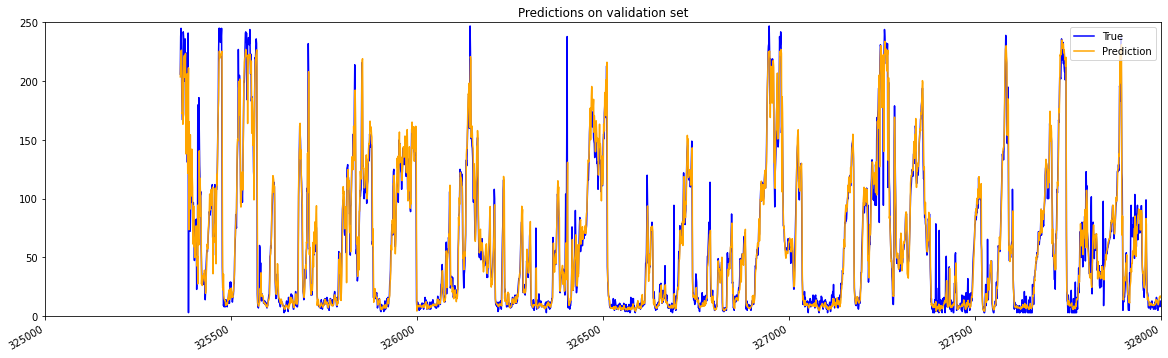

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(valid.iloc[CFG.seq_length:].index, valid_targets, color='b', label='True')
ax.plot(valid.iloc[CFG.seq_length:].index, valid_preds, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([325000, 328000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()

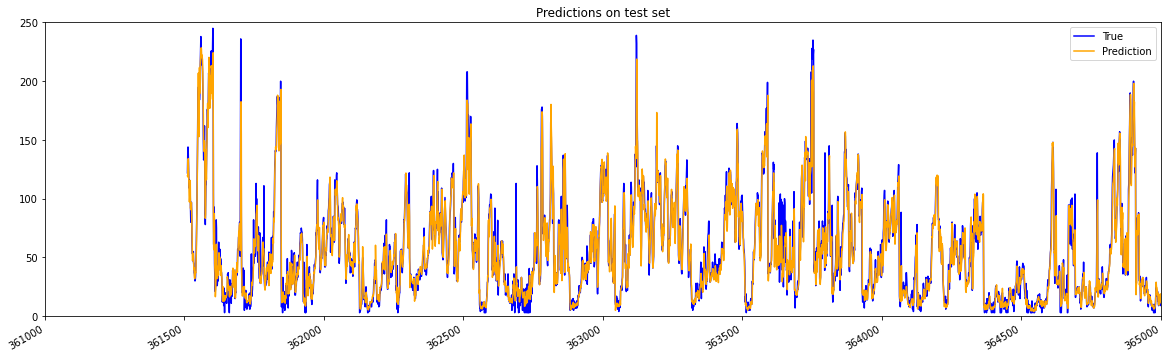

In [15]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test.iloc[CFG.seq_length:].index, test_targets, color='b', label='True')
ax.plot(test.iloc[CFG.seq_length:].index, test_preds, color='orange', label='Prediction')

ax.set_title("PM2.5", fontweight="bold", size=16)
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([361000, 365000, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on test set')
plt.show()